In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn import metrics
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from numpy import loadtxt
from keras.models import load_model
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


In [3]:
df = pd.read_csv(r"C:\Users\prera\Desktop\FinalProject\data\diabetes.csv")

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.shape

(768, 9)

In [6]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
for i in df.columns:
    print(f'{i} : {df[i].nunique()} values')

Pregnancies : 17 values
Glucose : 136 values
BloodPressure : 47 values
SkinThickness : 51 values
Insulin : 186 values
BMI : 248 values
DiabetesPedigreeFunction : 517 values
Age : 52 values
Outcome : 2 values


In [9]:
numerical_features = []
categorical_features = []

for i in df.columns:
    if df[i].nunique()>7:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

In [10]:
print(len(numerical_features),'Numerical features: \n', numerical_features)
print('\n\n',len(categorical_features),'Categorical features:\n ', categorical_features)

8 Numerical features: 
 ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


 1 Categorical features:
  ['Outcome']


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [12]:
df.drop(['SkinThickness', 'Insulin'], axis = 1, inplace=True)

In [13]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

# EDA

In [14]:
df.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

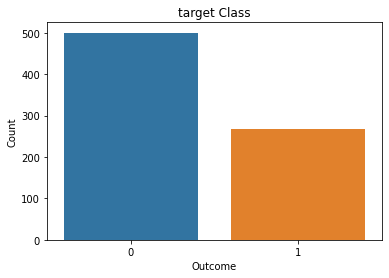

Percent of Diabetes outcome:  34.9 %
Percent of not a Diabetes outcome:  65.1 %


In [15]:
sns.countplot(x='Outcome',data=df)
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.title("target Class")
plt.show()
print('Percent of Diabetes outcome: ',round(len(df[df['Outcome']== 1])/len(df['Outcome'])*100,2),"%")
print('Percent of not a Diabetes outcome: ',round(len(df[df['Outcome']== 0])/len(df['Outcome'])*100,2),"%")

In [16]:
df

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,33.6,0.627,50,1
1,1,85,66,26.6,0.351,31,0
2,8,183,64,23.3,0.672,32,1
3,1,89,66,28.1,0.167,21,0
4,0,137,40,43.1,2.288,33,1
...,...,...,...,...,...,...,...
763,10,101,76,32.9,0.171,63,0
764,2,122,70,36.8,0.340,27,0
765,5,121,72,26.2,0.245,30,0
766,1,126,60,30.1,0.349,47,1


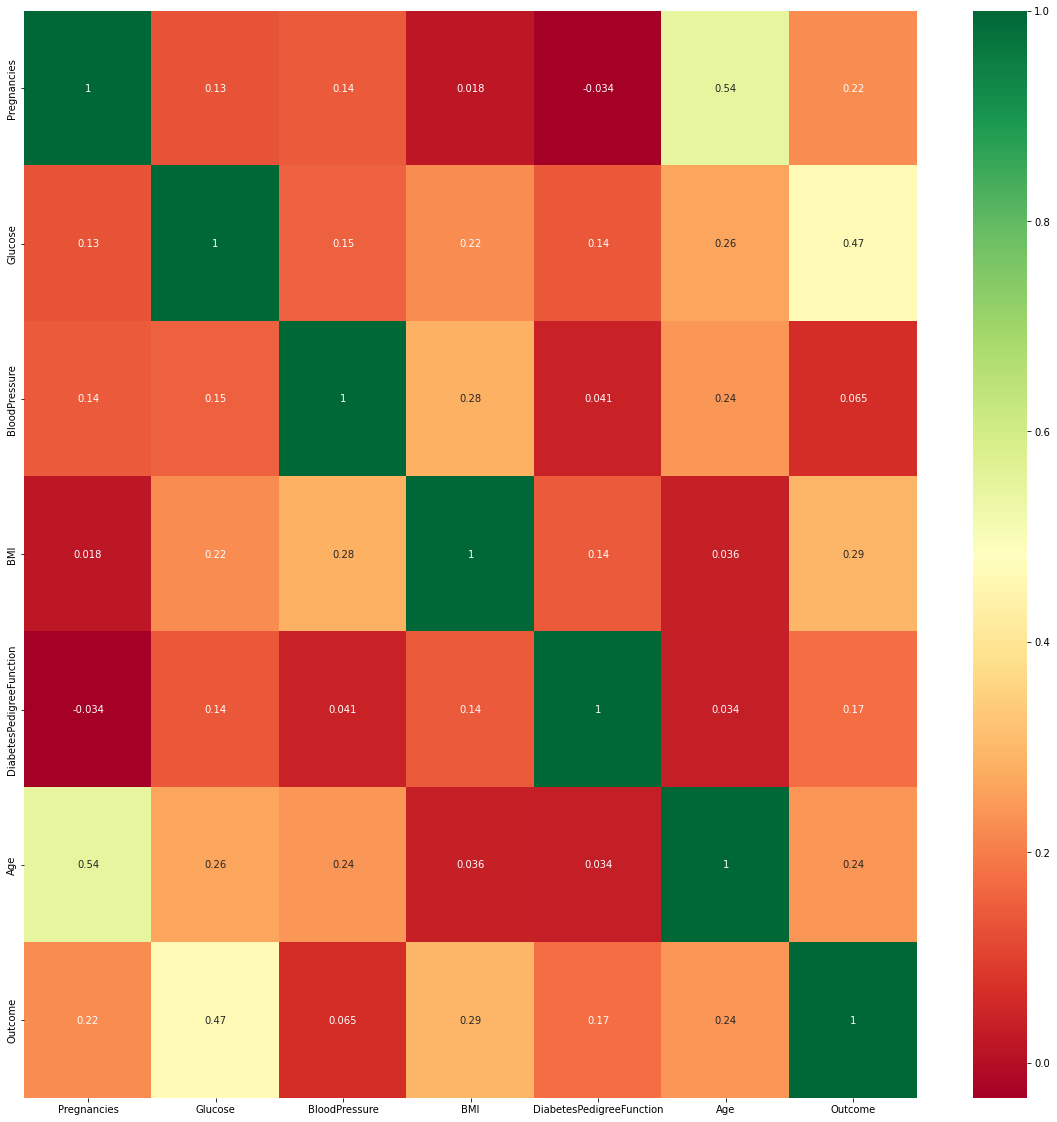

In [17]:
corr = df.corr()
plt.figure(figsize=(20,20))
g = sns.heatmap(corr, annot=True, cmap = "RdYlGn")

In [18]:
df.corr()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.281805,0.041265,0.239528,0.065068
BMI,0.017683,0.221071,0.281805,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.292695,0.173844,0.238356,1.000000


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   BMI                       768 non-null    float64
 4   DiabetesPedigreeFunction  768 non-null    float64
 5   Age                       768 non-null    int64  
 6   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 42.1 KB


# Splitting in X and Y

In [20]:
x = df.drop('Outcome', axis=1)
y = df.Outcome

y.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [21]:
sc = MinMaxScaler()
x = sc.fit_transform(x)
x

array([[0.35294118, 0.74371859, 0.59016393, 0.50074516, 0.23441503,
        0.48333333],
       [0.05882353, 0.42713568, 0.54098361, 0.39642325, 0.11656704,
        0.16666667],
       [0.47058824, 0.91959799, 0.52459016, 0.34724292, 0.25362938,
        0.18333333],
       ...,
       [0.29411765, 0.6080402 , 0.59016393, 0.390462  , 0.07130658,
        0.15      ],
       [0.05882353, 0.63316583, 0.49180328, 0.4485842 , 0.11571307,
        0.43333333],
       [0.05882353, 0.46733668, 0.57377049, 0.45305514, 0.10119556,
        0.03333333]])

# OverSampling using SMOTE

In [22]:
print(Counter(y))

oversample = SMOTE()
x, y = oversample.fit_resample(x, y)

Counter(y)

Counter({0: 500, 1: 268})


Counter({1: 500, 0: 500})

# Train-Test Split

In [23]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.15,random_state=0)

In [24]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(850, 6)
(150, 6)
(850,)
(150,)


In [25]:
x_test
x_test_1=x_test[2,]

x_test_1=x_test_1.reshape(1,-1)

x_test_1.dtype

dtype('float64')

# Logistic Regression

In [26]:
diabeteslr=LogisticRegression(solver='liblinear')
diabeteslr.fit(x_train,y_train)

LogisticRegression(solver='liblinear')

In [27]:
# Accuracy
y_pred = diabeteslr.predict(x_test)
print('Accuracy of logistic regression classifier on test set:',diabeteslr.score(x_test, y_test))

Accuracy of logistic regression classifier on test set: 0.78


[[62 19]
 [14 55]]


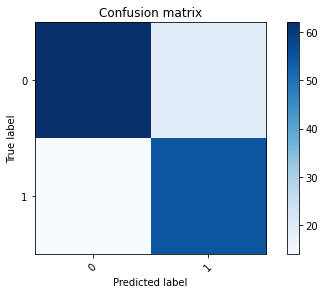

In [28]:
# Print and plot confusion matrix   
cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(cm,['0','1'])

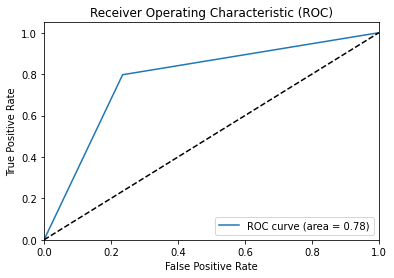

In [29]:
# Plot roc curve
plot_roc(y_pred,y_test)

In [30]:
# Print Classification Report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.77      0.79        81
           1       0.74      0.80      0.77        69

    accuracy                           0.78       150
   macro avg       0.78      0.78      0.78       150
weighted avg       0.78      0.78      0.78       150



# Naive Bayes

In [31]:
from sklearn.naive_bayes import BernoulliNB
diabetesNB = BernoulliNB()
y_pred = diabetesNB.fit(x_train, y_train)
y_pred = diabetesNB.predict(x_test)

In [32]:
#Acuracy
print("Bernoulli Naive Bayes model accuracy on test set:",metrics.accuracy_score(y_test, y_pred))

Bernoulli Naive Bayes model accuracy on test set: 0.56


[[23 58]
 [ 8 61]]


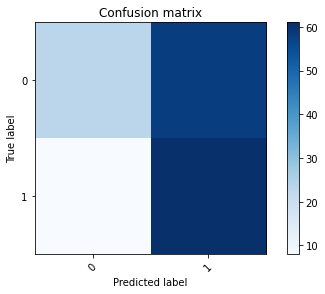

In [33]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(cm,['0','1'])

In [34]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.28      0.41        81
           1       0.51      0.88      0.65        69

    accuracy                           0.56       150
   macro avg       0.63      0.58      0.53       150
weighted avg       0.64      0.56      0.52       150



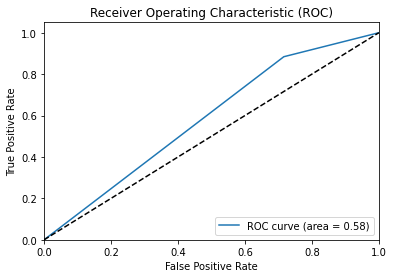

In [35]:
plot_roc(y_pred,y_test)

# Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
diabetesrf = RandomForestClassifier()

#Train the model using the training sets y_pred=clf.predict(X_test)
diabetesrf.fit(x_train,y_train)

y_pred=diabetesrf.predict(x_test)

In [37]:
#Accuracy
print("Accuracy of Random forest on test set:",metrics.accuracy_score(y_test, y_pred))

Accuracy of Random forest on test set: 0.86


[[68 13]
 [ 8 61]]


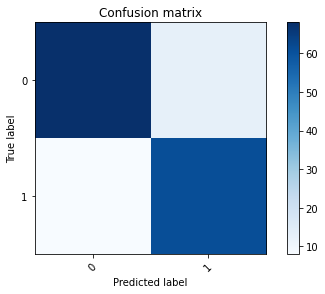

In [38]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(cm,['0','1'])

In [39]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.84      0.87        81
           1       0.82      0.88      0.85        69

    accuracy                           0.86       150
   macro avg       0.86      0.86      0.86       150
weighted avg       0.86      0.86      0.86       150



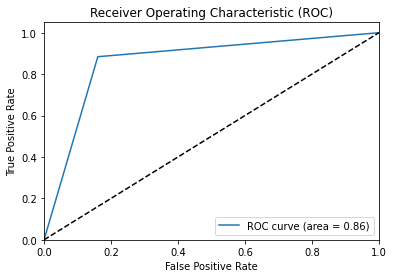

In [40]:
plot_roc(y_pred,y_test)

# XG-Boost

In [41]:
from numpy import loadtxt
from xgboost import XGBClassifier
diabetesxgb=XGBClassifier()
diabetesxgb.fit(x_train,y_train)

[19:58:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [42]:
y_pred = diabetesxgb.predict(x_test)
predictions = [round(value) for value in y_pred]

In [43]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy for XGBoost on test set:", accuracy)

Accuracy for XGBoost on test set: 0.8466666666666667


In [44]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85        81
           1       0.81      0.87      0.84        69

    accuracy                           0.85       150
   macro avg       0.85      0.85      0.85       150
weighted avg       0.85      0.85      0.85       150



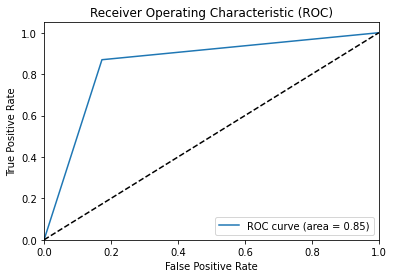

In [45]:
plot_roc(y_pred,y_test)

# Neural Network

In [46]:
diabetesnnmodel = Sequential()
diabetesnnmodel.add(Dense(64, input_dim=x_train.shape[1], activation='tanh'))
diabetesnnmodel.add(Dense(32, activation='tanh'))
diabetesnnmodel.add(Dense(16, activation='tanh'))
diabetesnnmodel.add(Dense(1, activation='sigmoid'))

diabetesnnmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
                        verbose=2, mode='min')

# chckpt = ModelCheckpoint(filepath='.weights.hdf5', verbose=1, save_best_only=True)

diabetesnnmodel.fit(x_train,y_train,verbose=2,epochs=200, batch_size=20, callbacks=[monitor], validation_split=0.25)

Epoch 1/200
32/32 - 0s - loss: 0.6802 - accuracy: 0.5447 - val_loss: 0.6678 - val_accuracy: 0.6432

Epoch 00001: val_loss improved from inf to 0.66779, saving model to .weights.hdf5
Epoch 2/200
32/32 - 0s - loss: 0.6476 - accuracy: 0.6358 - val_loss: 0.6510 - val_accuracy: 0.6573

Epoch 00002: val_loss improved from 0.66779 to 0.65102, saving model to .weights.hdf5
Epoch 3/200
32/32 - 0s - loss: 0.6202 - accuracy: 0.6907 - val_loss: 0.6221 - val_accuracy: 0.6854

Epoch 00003: val_loss improved from 0.65102 to 0.62207, saving model to .weights.hdf5
Epoch 4/200
32/32 - 0s - loss: 0.5981 - accuracy: 0.7049 - val_loss: 0.6072 - val_accuracy: 0.6901

Epoch 00004: val_loss improved from 0.62207 to 0.60723, saving model to .weights.hdf5
Epoch 5/200
32/32 - 0s - loss: 0.5864 - accuracy: 0.7096 - val_loss: 0.5905 - val_accuracy: 0.6995

Epoch 00005: val_loss improved from 0.60723 to 0.59052, saving model to .weights.hdf5
Epoch 6/200
32/32 - 0s - loss: 0.5792 - accuracy: 0.7190 - val_loss: 0.581

In [47]:
diabetesnnmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________


In [48]:
y_pred = diabetesnnmodel.predict(x_test)

In [49]:
argmax = []
for val in y_pred:
    if val >= 0.5:
      argmax.append(1)
    else:
        argmax.append(0)
argmax[:10]

[1, 1, 1, 0, 0, 1, 0, 1, 1, 0]

In [50]:
accuracy = accuracy_score(y_test,argmax)
print("Accuracy for neural network on test set:", accuracy)

Accuracy for neural network on test set: 0.8


[[62 19]
 [11 58]]


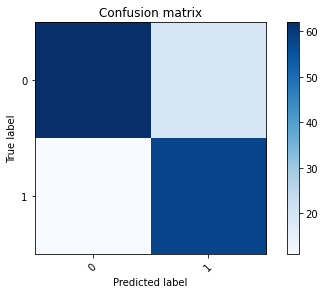

In [51]:
cm = confusion_matrix(y_test, argmax)
print(cm)
plot_confusion_matrix(cm,['0','1'])

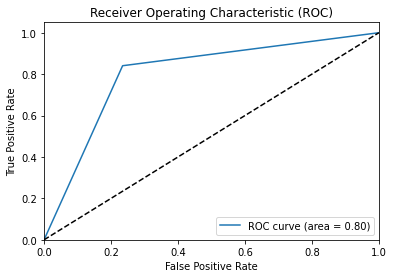

In [52]:
plot_roc(argmax,y_test)

# SAVING MODEL

In [53]:
import pickle
pickle.dump(diabetesrf,open("C:/Users/prera/Desktop/FINALPROJECT/models/diabetes_model.pkl","wb"))

In [54]:
x_test_1=np.array(x_test_1)

In [55]:
x_test_1+=.15

In [56]:
# x_test_1=x_test[1,]

# x_test_1=x_test_1.reshape(1,-1)

# x_test_1
import pickle
model=pickle.load(open("C:/Users/prera/Desktop/Project/Diabetes_API/diabetes_model.pkl","rb"))
result = model.predict_proba(x_test_1)
print(result[0])


[0.09837409 0.90162591]


In [57]:
result.dtype

dtype('float64')

In [58]:
np.argmax(model.predict(x_test_1))

0

# NN save

In [59]:
# diabetesnnmodel.save("diabetes.h5")

In [ ]:
# model = load_model('diabetes.h5')
# # summarize model.
# model.summary()
# score = model.evaluate(x_test, y_test, verbose=0)
# # print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
# resultnn=model.predict_proba(x_test_1)
# print(resultnn)